Building the dataset of numerical data

In [ ]:
#### STOP - ONLY if needed
# Allows printing full text
import pandas as pd
pd.set_option('display.max_colwidth', None)


#mid_keywords = best_keywords(data, 1, 0.49, 0.51)    # same as above, but for average papers
#low_keywords = best_keywords(data, 1, 0.03, 0.05)    # same as above, but for poor papers


In [ ]:
### PUT MAIN HERE ###

In [1]:
# Machine Learning Challenge
# Course: Machine Learning (880083-M-6)
# Group 58
 
##########################################
#             Import packages            #
##########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import yake  #NOTE: with Anaconda: conda install -c conda-forge yake

##########################################
#      Import self-made functions        #
##########################################
from CODE.data_preprocessing.split_val import split_val
from CODE.data_preprocessing.find_outliers_tukey import find_outliers_tukey

#feature based on the title of the paper
from CODE.features.length_title import length_title

# features based on 'field_of_study' column 
from CODE.features.field_variety import field_variety         
from CODE.features.field_popularity import field_popularity
from CODE.features.field_citations_avarage import field_citations_avarage 

# features based on the topics of the paper
from CODE.features.topic_citations_avarage import topic_citations_avarage
from CODE.features.topic_variety import topics_variety
from CODE.features.topic_popularity import topic_popularity
from CODE.features.topic_citations_avarage import topic_citations_avarage

# features based on the abstract of the paper
from CODE.features.keywords import best_keywords
from CODE.features.abst_words import abst_words
from CODE.features.abst_words import abst_count

# features based on the venue of the paper
from CODE.features.venue_popularity import venue_popularity
from CODE.features.venue_citations import venues_citations

from CODE.features.age import age

# features based on the authors of the paper
from CODE.features.author_h_index import author_h_index
from CODE.features.paper_h_index import paper_h_index
from CODE.features.team_size import team_size
from CODE.features.author_database import author_database


##########################################
#              Load datasets             #
##########################################
# Main datasets
data = pd.read_json('DATA/train.json')      # Training set
test = pd.read_json('DATA/test.json')       # Test set

# Author-centric datasets
#   These datasets were made using our self-made functions 'citations_per_author' (for the author_citation_dic)
#   These functions took a long time to make (ballpark ~10 minutes on a laptop in 'silent mode'), so instead we 
#   decided to run this function once, save the data, and reload the datasets instead of running the function again. 
import pickle
with open('my_dataset1.pickle', 'rb') as dataset:
    author_citation_dic = pickle.load(dataset)
with open('my_dataset2.pickle', 'rb') as dataset2:
    author_db = pickle.load(dataset2)


##########################################
#        Missing values handling         #
##########################################

# Missing values for feature 'fields_of_study'
data.loc[data['fields_of_study'].isnull(), 'fields_of_study'] = ""

# Missing values for feature 'title'
data.loc[data['title'].isnull(), 'title'] = ""

# Missing values for feature 'abstract'
data.loc[data['abstract'].isnull(), 'abstract'] = ""
    
# Missing values for features 'authors'
data.loc[data['authors'].isnull(), 'authors'] = ""

# Missing values for feature 'venue'
data.loc[data['venue'].isnull(), 'venue'] = ""
    
# Missing values for feature 'year'
# data.loc[data['fields_of_study'].isnull(), 'fields_of_study'] = mean(year) 
        #   Take mean by venue instead
        #       If venue not known, take something else?

# Missing values for feature 'references'
data.loc[data['references'].isnull(), 'references'] = ""

# Missing values for feature 'topics'
data.loc[data['topics'].isnull(), 'topics'] = ""

# Missing values for feature 'is_open_access'
#data.loc[data['is_open_access'].isnull(), 'is_open_access'] = "" 
        #   Take most frequent occurrence for venue
        #       If venue not known, do something else?
    
##########################################
#       Create basic numeric df          #
##########################################
end = len(data)
num_X = data.loc[ 0:end+1 , ('doi', 'citations', 'year', 'references') ]  ##REMOVE DOI


##########################################
#            Feature creation            #
##########################################
"""
FEATURE DATAFRAME: num_X

ALL: After writing a funtion to create a feature, please incorporate your new feature as a column on the dataframe below.
This is the dataframe we will use to train the models.

DO NOT change the order in this section if at all possible
"""
num_X['title_length'] = length_title(data)      # returns a numbered series
num_X['field_variety'] = field_variety(data)    # returns a numbered series 
num_X['field_popularity'] = field_popularity(data) # returns a numbered series
# num_X['field_citations_avarage'] = field_citations_avarage(data) # returns a numbered series
num_X['team_sz'] = team_size(data)           # returns a numbered series
num_X['topic_var'] = topics_variety(data)    # returns a numbered series
num_X['topic_popularity'] = topic_popularity(data) # returns a numbered series
num_X['topic_citations_avarage'] = topic_citations_avarage(data) # returns a numbered series
num_X['venue_popularity'], num_X['venue'] = venue_popularity(data)  # returns a numbered series and a pandas.Series of the 'venues' column reformatted 
num_X['open_access'] = pd.get_dummies(data["is_open_access"], drop_first = True)  # returns pd.df (True = 1)
num_X['age'] = age(data)               # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
num_X['venPresL'] = venues_citations(data)   # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
keywords = best_keywords(data, 1, 0.954, 0.955)    # from [data set] get [integer] keywords from papers btw [lower bound] and [upper bound] quantiles; returns list
num_X['has_keyword'] = abst_words(data, keywords)#returns a numbered series: 1 if any of the words is present in the abstract, else 0
num_X['keyword_count'] = abst_count(data, keywords) # same as above, only a count (noot bool)

# Author H-index
author_db, reformatted_authors = author_database(data)
data['authors'] = reformatted_authors
num_X['h_index'] = paper_h_index(data, author_citation_dic) # Returns a numbered series. Must come after author names have been reformatted.

field_avg_cit = num_X.groupby('field_variety').citations.mean()
for field, field_avg in zip(field_avg_cit.index, field_avg_cit):
    num_X.loc[num_X['field_variety'] == field, 'field_cit'] = field_avg


"""
END do not reorder
"""

##########################################
#    Deal with specific missing values   #
##########################################
# Open_access, thanks to jreback (27th of July 2016) https://github.com/pandas-dev/pandas/issues/13809
OpAc_by_venue = num_X.groupby('venue').open_access.apply(lambda x: x.mode()) # Take mode for each venue
OpAc_by_venue = OpAc_by_venue.to_dict()
missing_OpAc = num_X.loc[num_X['open_access'].isnull(),]
for i, i_paper in missing_OpAc.iterrows():
    venue = i_paper['venue']
    doi = i_paper['doi']
    index = num_X[num_X['doi'] == doi].index[0]
    if venue in OpAc_by_venue.keys():   # If a known venue, append the most frequent value for that venue
        num_X[num_X['doi'] == doi]['open_access'] = OpAc_by_venue[venue] # Set most frequent occurrence 
    else:                               # Else take most occurring value in entire dataset
        num_X.loc[index,'open_access'] = num_X.open_access.mode()[0] # Thanks to BENY (2nd of February, 2018) https://stackoverflow.com/questions/48590268/pandas-get-the-most-frequent-values-of-a-column

### Drop columns containing just strings
num_X = num_X.drop(['venue', 'doi', 'field_variety'], axis = 1)
num_X = num_X.dropna()


##########################################
#            Train/val split             #
##########################################

## train/val split
X_train, X_val, y_train, y_val = split_val(num_X, target_variable = 'citations')


"""
INSERT outlier detection on X_train here - ALBERT
"""

##########################################
#            Outlier detection           #
##########################################
### MODEL code for outlier detection
### names: X_train, X_val, y_train, y_val

# print(list(X_train.columns))

out_y = (find_outliers_tukey(x = y_train['citations'], top = 93, bottom = 0))[0]
out_rows = out_y

# out_X = (find_outliers_tukey(x = X_train['team_sz'], top = 99, bottom = 0))[0]
# out_rows = out_y + out_X

out_rows = sorted(list(set(out_rows)))

# print("X_train:")
# print(X_train.shape)
X_train = X_train.drop(labels = out_rows)
# print(X_train.shape)
# print()
# print("y_train:")
# print(y_train.shape)
y_train = y_train.drop(labels = out_rows)
# print(y_train.shape)

# Potential features to get rid of: team_sz


##########################################
#         Model implementations          #
##########################################
"""
IMPLEMENT models here
NOTE: Please do not write over X_train, X_val, y_train, y_val in your model - make new variables if needed


"""

#-----------simple regression, all columns
"""
MODEL RESULTS:
R2: 0.03724
MSE: 33.38996
"""
#-----------logistic regression, all columns
"""
MODEL RESULTS:
R2: 0.006551953988217396
MSE: 34.07342328208346
"""
#-----------SGD regression, all columns
"""
# MODEL RESULTS:
# Best outcome: ('constant', 0.01, 'squared_error', 35.74249957361433, 0.04476790061780822)
"""

#-----------polynomial regression, all columns
"""
"""


#model.fit(X_train, y_train)
#print('Best score: ', model.best_score_)
#print('Best parameters: ', model.best_params_)
#y_pred = model.predict(X_val)

#from sklearn.metrics import r2_score
#print(r2_score(y_val,y_pred))


# import json
#with open("sample.json", "w") as outfile:
    #json.dump(dictionary, outfile)

'\n'

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------------ LETS EXPLORE!!! ------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [ ]:
### FOR: exploring the new dataframe with numerical columns
# --> NOTE: it would be more efficient to combine these first and only expand the df once (per addition type)

num_X

In [ ]:
### FOR: explore data train/val split  (should be 6470 train rows and 3188 validation rows)
# names: X_train, X_val, y_train, y_val
print("number of keywords:", len(keywords))
print("total train rows:", X_train.shape)
print("numer w keyword:", sum(X_train['has_keyword']))
print()
print(keywords)

#X_val
#y_train
#y_val
#6210 of 6313
#6136 (of 6313) for 1 keyword from the top 1% of papers
#4787 for 2 keywords from top .01% of papers (correlation: 0.036)
#2917 for 1 keyword from top .01% of papers (correlation: 0.049)

In [ ]:
"""
Look at some correlations - full num_X
"""
# names: X_train, X_val, y_train, y_val

# From: https://www.kaggle.com/ankitjha/comparing-regression-models
import seaborn as sns
corr_mat = num_X.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')


In [ ]:
"""
Look at some correlations - X_train
NOTE: there is no y here
"""
# names: X_train, X_val, y_train, y_val

#temp = y_train hstack X_train


# From: https://www.kaggle.com/ankitjha/comparing-regression-models
corr_mat = X_train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------- LETS CODE!!! --------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [2]:
print(list(X_train.columns))


['year', 'references', 'title_length', 'field_popularity', 'team_sz', 'topic_var', 'topic_popularity', 'topic_citations_avarage', 'venue_popularity', 'open_access', 'age', 'venPresL', 'has_keyword', 'keyword_count', 'h_index', 'field_cit']


In [ ]:
"""
Choose your columns
"""

#X_train_small = X_train.loc[ : , 'topic_var':'h_index'].copy()
#X_val_small = X_val.loc[ : , 'topic_var':'h_index'].copy()

drops = ['year', 'team_sz', 'has_keyword']
X_train_small = X_train.copy()
X_train_small.drop(drops, inplace = True, axis=1)

X_val_small = X_val.copy()
X_val_small.drop(drops, inplace = True, axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [1]:
from CODE.models.regression import simple_linear
from CODE.models.regression import log_reg

summaries = list(X_train.columns)
print(summaries)

for i in range(len(summaries)):
#    fs = summaries[:i] + summaries[i+1:]
    X_train_small = X_train.copy()
    X_val_small = X_val.copy()
    drops = summaries[i]
    X_train_small.drop(drops, inplace = True, axis=1)
    X_val_small.drop(drops, inplace = True, axis=1)

    print("dropped:", summaries[i])
    
    simple_linear(X_train_small, y_train, X_val_small, y_val)  #dropping venue_popularity helps a tiny bit
#    log_reg(X_train_small, y_train, X_val_small, y_val)

# log_reg
# helps to drop: year, field_popularity, team_size, topic_var, age, has_keyword, keyword_count
# hurts to drop: references, title length, topic_popularity, opic_citations_avarage, venue_popularity(!), 
# venPresL(!), h_index(!), field_cit

NameError: name 'X_train' is not defined

In [18]:
playX = num_X.copy()

In [33]:
playX = playX[playX['field_cit'] < 30]

<AxesSubplot:xlabel='field_cit', ylabel='citations'>

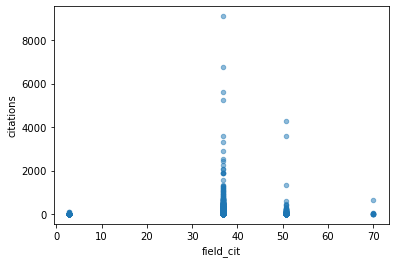

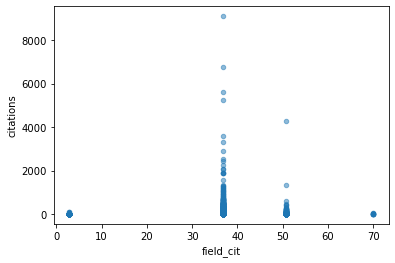

In [35]:
num_X.plot.scatter(x="field_cit", y="citations", alpha=0.5) 
playX.plot.scatter(x="field_cit", y="citations", alpha=0.5) 

In [ ]:
print(list(num_X.columns))

['citations', 'year', 'references', 'title_length', 'field_popularity', 'team_sz', 'topic_var', 'topic_popularity', 'topic_citations_avarage', 'venue_popularity', 'open_access', 'age', 'venPresL', 'has_keyword', 'keyword_count', 'h_index', 'field_cit']


<AxesSubplot:xlabel='field_cit', ylabel='citations'>

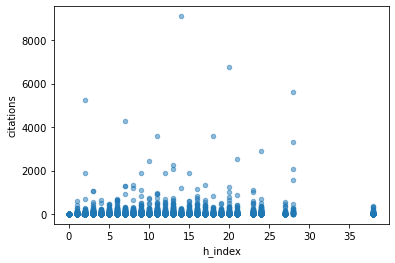

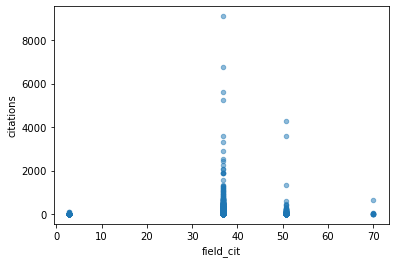

In [32]:
import matplotlib as plt
#num_X.plot.scatter(x="year", y="citations", alpha=0.5)
#num_X.plot.scatter(x="references", y="citations", alpha=0.5)  # might have 3 outliers
#num_X.plot.scatter(x="title_length", y="citations", alpha=0.5) 
#num_X.plot.scatter(x="team_sz", y="citations", alpha=0.5)  # might have 3 outliers
#num_X.plot.scatter(x="topic_var", y="citations", alpha=0.5) # one outlier; maybe anything over 40
#num_X.plot.scatter(x="topic_popularity", y="citations", alpha=0.5)
#num_X.plot.scatter(x="topic_citations_average", y="citations", alpha=0.5)
#num_X.plot.scatter(x="venue_popularity", y="citations", alpha=0.5)
#num_X.plot.scatter(x="open_access", y="citations", alpha=0.5)
#num_X.plot.scatter(x="age", y="citations", alpha=0.5)
#num_X.plot.scatter(x="venPresL", y="citations", alpha=0.5)  # anything over 300 as outlier?
#num_X.plot.scatter(x="has_keyword", y="citations", alpha=0.5)
#num_X.plot.scatter(x="keyword_count", y="citations", alpha=0.5)
#num_X.plot.scatter(x="h_index", y="citations", alpha=0.5)  # anything over 35 as outlier?
#num_X.plot.scatter(x="field_cit", y="citations", alpha=0.5)


In [ ]:
X_train_small
#X_val_small

In [ ]:
def abst_categories (the_data, keywords, mid_keywords, low_keywords):
    abst = the_data['abstract']
    counts = []
    abst_key = []    

    for i in abst:
        if i == None:
            abst_key.append(0)
            continue
        else:
            high = 0
            for word in keywords:
                if word in i.lower():
                    high += 1
            
            mid = 0
            for word in mid_keywords:
                if word in i.lower():
                    mid += 1

            low = 0
            for word in low_keywords:
                if word in i.lower():
                    low +=1

        
#        abst_key = np.argmax(abst_key)
#        abst_key = (max(abst_key)).index


    return pd.Series(abst_key)    
    
    
print(sum(abst_categories (data, keywords, mid_keywords, low_keywords)))  #9499 rows

In [ ]:
"""
Remove outliers
NOTE: can't rerun this code without restarting the kernal
"""
#names: X_train, X_val, y_train, y_val
#print(list(X_train.columns))

# print("citations:", find_outliers_tukey(x = y_train['citations'], top = 93, bottom = 0))

# print("year:", find_outliers_tukey(X_train['year'], top = 74, bottom = 25))  # seems unnecessary
# print("references:", find_outliers_tukey(X_train['references'], top = 90, bottom = 10))  # seems unnecessary
# print("team_size:", find_outliers_tukey(X_train['team_size'], top = 99, bottom = 0))  # Meh
# print("topic_variety:", find_outliers_tukey(X_train['topic_variety'], top = 75, bottom = 10))  # not much diff btw top and normal
# print("age:", find_outliers_tukey(X_train['age'], top = 90, bottom = 10))  # Meh
# print("open_access:", find_outliers_tukey(X_train['open_access'], top = 100, bottom = 0))  # Not necessary: boolean
# print("has_keyword:", find_outliers_tukey(X_train['has_keyword'], top = 100, bottom = 0))  # Not necessary: boolean
# print("title_length:", find_outliers_tukey(X_train['title_length'], top = 90, bottom = 10))  # Meh
# print("field_variety:", find_outliers_tukey(X_train['field_variety'], top = 90, bottom = 10))  # seems unnecessary
# print("venue_freq:", find_outliers_tukey(X_train['venue_freq'], top = 90, bottom = 10))  # seems unnecessary


out_y = (find_outliers_tukey(x = y_train['citations'], top = 95, bottom = 0))[0]
#out_X = (find_outliers_tukey(x = X_train['team_size'], top = 99, bottom = 0))[0]
out_rows = out_y
#out_rows = out_y + out_X
out_rows = sorted(list(set(out_rows)))

print("X_train:")
print(X_train.shape)
X_train = X_train.drop(labels = out_rows)
print(X_train.shape)
print()
print("y_train:")
print(y_train.shape)
y_train = y_train.drop(labels = out_rows)
print(y_train.shape)




In [ ]:
X_train

In [ ]:
# Create a mini version of the main 'data' dataframe

import pandas as pd
import numpy as np
# %pwd
# %cd C:\Users\r_noc\Desktop\Python\GIT\machinelearning
    
play = data.sample(100, replace = False, axis = 0, random_state = 123)  


print(play.shape)
# print(play['abstract'])

print(list(play.columns))
# play['has_keyword'] = np.nan
# print(play.shape)
# play

In [ ]:
from sklearn.linear_model import PoissonRegressor



















In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_small)
X_val_z  =scaler.transform(X_val_small)

polynomial_features = PolynomialFeatures(degree = 2)
x_train_poly = polynomial_features.fit_transform(X_train_z)
x_val_poly = polynomial_features.transform(X_val_z)

model = LinearRegression()
model.fit(x_train_poly, y_train)
y_poly_pred = model.predict(x_val_poly)

print(r2_score(y_val, y_poly_pred))   # -0.04350391168707901
print(mean_absolute_error(y_val, y_poly_pred))    # 32.65668266590838

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_small)
X_val_z  =scaler.transform(X_val_small)

model = PolynomialFeatures(degree = 2)
X_poly = model.fit_transform(X_train_z)
model.fit(X_poly, y_train)
model2 = LinearRegression()
model2.fit(X_poly, y_train)

y_pred_val = model2.predict(model.fit_transform(X_val_z))

print(r2_score(y_val, y_pred_val))   #0.03724015197555319
print(mean_absolute_error(y_val, y_pred_val))   #33.38996938585591

In [ ]:
#names: X_train, X_val, y_train, y_val

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_small)
X_val_z  =scaler.transform(X_val_small)
y_ravel = np.ravel(y_train)
lr = [ 1.1, 1, .1, .01, .001, .0001]
settings = []
for learning_rate in ['constant', 'optimal', 'invscaling']:
    for loss in ['squared_error', 'huber']:
        for eta0 in lr:
            model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, loss=loss,random_state=666, max_iter=5000)
            model.fit(X_train_z, y_ravel)
            y_pred = model.predict(X_val_z)
            
            mae = mean_absolute_error(y_val, y_pred)
            r2 =  r2_score(y_val, y_pred)
            settings.append((learning_rate, eta0, loss, mae, r2))
            print(settings[-1])

# Best outcome: ('constant', 0.01, 'squared_error', 35.74249957361433, 0.04476790061780822)
# With small: ('invscaling', 1, 'squared_error', 48.92137807970932, 0.05128477811871335)

In [ ]:
X_train
